In [44]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import cv2 as cv
import os
import glob
import pandas as pd
import time
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image
from scipy.spatial.transform import Rotation as R
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.optimize import least_squares
from scipy.signal import savgol_filter

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

In [4]:
# -------------------------------
# SETTINGS: file paths for markers
# -------------------------------
# List of npy files for the 3D points for each marker (one file per marker)
marker_points_files = [
    r"D:\FST_972_FF_Sphere\FST_972_Run\point1_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point2_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point3_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point4_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point5_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point6_3d_v2.npy"
]

# List of npy files for the corresponding frame numbers for each marker
marker_frames_files = [
    r"D:\FST_972_FF_Sphere\FST_972_Run\point1_3d_frames_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point2_3d_frames_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point3_3d_frames_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point4_3d_frames_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point5_3d_frames_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point6_3d_frames_v2.npy"
]

num_markers = len(marker_points_files)
markers_data = []  # Will hold tuples (frames, points) for each marker

In [5]:
# -------------------------------
# LOAD DATA FOR EACH MARKER
# -------------------------------
for i in range(num_markers):
    # Load 3D points, expected shape: (N_i, 3)
    points = np.load(marker_points_files[i])
    # Load frame numbers, expected shape: (N_i,)
    frames = np.load(marker_frames_files[i])
    
    # Convert frames to integer if necessary
    frames = frames.astype(int)
    
    markers_data.append((frames, points))
    
print("Loaded data for", num_markers, "markers.")


Loaded data for 6 markers.


### Identifying Camera Frames where all 6 markers of the sphere are visible

In [6]:
# Use only camera frames, where 3d points of all 6 markers were detected.
# FIND COMMON FRAME NUMBERS 
# -------------------------------
# Start with the frame numbers from the first marker
common_frames = set(markers_data[0][0])
for frames, _ in markers_data[1:]:
    common_frames = common_frames.intersection(set(frames))
    
common_frames = sorted(list(common_frames))
print("Number of common frames across all markers:", len(common_frames))

Number of common frames across all markers: 456


In [ ]:
common_frames

### Get the 3d points of all the markers in each common frame.

In [7]:
# -------------------------------
# MAP 3D POINTS FOR EACH COMMON FRAME
# -------------------------------
# Create a dictionary mapping each common frame to a (6, 3) array.
# Each row in the array corresponds to one marker's 3D coordinates for that frame.
frame_to_points = {}

for frame in common_frames:
    frame_points = []
    for frames, points in markers_data:
        # Find index for the current frame in this marker's frames array.
        idx = np.where(frames == frame)[0]
        if len(idx) == 0:
            # In theory, this should not happen for common frames.
            frame_points.append(np.array([np.nan, np.nan, np.nan]))
        else:
            # Append the corresponding 3D coordinates.
            frame_points.append(points[idx[0]])
    # Stack the 6 marker points into a (6, 3) array.
    frame_to_points[frame] = np.vstack(frame_points)

# -------------------------------
# OPTIONAL: Convert mapping to a list for further processing
# -------------------------------
# For example, create a sorted list of frames and a list of corresponding (6, 3) arrays.
sorted_frames = np.array(common_frames)
points_per_frame = np.array([frame_to_points[frame] for frame in sorted_frames])
# points_per_frame now has shape (num_common_frames, 6, 3)

print("points_per_frame shape:", points_per_frame.shape)

points_per_frame shape: (456, 6, 3)


In [22]:
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\points_per_frame.npy",points_per_frame)

In [8]:
num_frames = points_per_frame.shape[0]

## Reconstruct Sphere and calculate its center, radius

In [28]:
def fit_sphere_center_and_radius(points, known_radius=None, initial_radius=None, initial_center=None, weight_known=1):
    """
    Fit the sphere center and radius to a set of 3D points using non-linear least squares.
    The sphere is defined by:
        (x - cx)^2 + (y - cy)^2 + (z - cz)^2 = r^2
    For each point, the residual is:
        residual_i = sqrt((x_i - cx)^2 + (y_i - cy)^2 + (z_i - cz)^2) - r
    If known_radius is provided, an extra penalty term is added:
        penalty = weight_known * (r - known_radius)

        #compare total residuals vs penalty term to see if weight is too high
    
    Parameters:
        points (np.ndarray): Array of shape (N, 3) with the 3D points.
        known_radius (float, optional): The known sphere radius.
        initial_radius (float, optional): Initial guess for the radius.
        initial_center (np.ndarray, optional): Initial guess for the center. Defaults to the mean of the points.
        weight_known (float, optional): Multiplier for the known radius penalty.
    
    Returns:
        center (np.ndarray): Optimized sphere center (3,).
        radius (float): Optimized sphere radius.
    """
    if initial_center is None:
        initial_center = np.mean(points, axis=0)
    if initial_radius is None:
        initial_radius = np.mean(np.linalg.norm(points - initial_center, axis=1))
        
    # Concatenate the initial guesses for center and radius into one parameter vector.
    x0 = np.concatenate((initial_center, [initial_radius]))
    
    def residuals(params):
        center = params[:3]
        r = params[3]
        distances = np.linalg.norm(points - center, axis=1)
        # Residual for each point: distance from the center minus the candidate radius
        res = distances - r
        # If a known radius is provided, add an extra penalty term.
        if known_radius is not None:
            res = np.append(res, weight_known * (r - known_radius))
        return res

    result = least_squares(residuals, x0)
    fitted_params = result.x
    center = fitted_params[:3]
    radius = fitted_params[3]
    return center, radius

# Algorithm for calculating orientation 
def kabsch(P, Q):
    """
    Compute the optimal rotation matrix (R) that aligns points Q to points P.
    Both P and Q should be centered (i.e., zero mean).

    Parameters:
        P (np.ndarray): Array of shape (N, 3).
        Q (np.ndarray): Array of shape (N, 3).

    Returns:
        R (np.ndarray): Rotation matrix of shape (3, 3).
    """
    H = Q.T @ P
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    # Correct for reflection if necessary.
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    return R

# -----------------------------
# 3. Process each frame: Fit sphere (center and radius) and compute orientation
# -----------------------------

centers = []       # To store sphere center for each frame (shape: (num_frames, 3))
radii = []         # To store sphere radius for each frame (num_frames,)
orientations = []  # To store orientation (rotation matrix) for each frame (num_frames, 3, 3)

# Optional: set your known sphere radius (e.g., 50.0)
known_radius = 57.12/2
#known_radius=None
# Rearrange the columns of the points array to match the expected order: [X, Y, Z]
# points_per_frame_corrected = [frame[:, [0, 2, 1]] for frame in points_per_frame]
# Use the first frame as reference:
ref_points = points_per_frame[0]   # e.g., shape (6, 3)
center_ref, radius_ref = fit_sphere_center_and_radius(ref_points, known_radius=known_radius, weight_known=1)
#center_ref, radius_ref = fit_sphere_center_and_radius(ref_points)
centers.append(center_ref)
radii.append(radius_ref)
# Compute the reference "body configuration" (markers relative to the sphere center)
ref_body = ref_points - center_ref
orientations.append(np.eye(3))  # Define orientation of the first frame as identity

# Process subsequent frames
for i in range(1, num_frames):
    pts = points_per_frame[i]   # e.g., shape (6, 3)
    center, radius = fit_sphere_center_and_radius(pts, known_radius=known_radius, weight_known=1)
    #center, radius = fit_sphere_center_and_radius(pts)
    centers.append(center)
    radii.append(radius)
    
    # Compute current body configuration (markers relative to current center)
    current_body = pts - center
    # Compute the rotation that best aligns ref_body to current_body using Kabsch
    R_i = kabsch(ref_body, current_body)
    orientations.append(R_i)

# Convert lists to numpy arrays
centers = np.array(centers)           # shape (num_frames, 3)
radii = np.array(radii)               # shape (num_frames,)
orientations = np.array(orientations) # shape (num_frames, 3, 3)

# # Optionally, print the results
print("Fitted Centers:\n", centers)
print("Fitted Radii:\n", radii)
print("Orientations:\n", orientations)

Fitted Centers:
 [[-91.30393967 -33.23759613 693.28663306]
 [-91.16629703 -33.12636198 693.39337235]
 [-91.08972925 -33.18048726 693.55080871]
 ...
 [-12.45829912 -19.72075913 714.10985796]
 [-12.34057369 -19.8418047  713.97471514]
 [-12.24266886 -19.76371737 714.15059404]]
Fitted Radii:
 [28.56102223 28.56026048 28.56103228 28.560772   28.55760948 28.56005749
 28.55940837 28.55933466 28.56066501 28.55886284 28.55816558 28.55873422
 28.55677103 28.55770875 28.55616609 28.55536174 28.55525389 28.55608807
 28.55567604 28.55540443 28.55697354 28.5568734  28.55833721 28.55814457
 28.55892425 28.55880753 28.56011979 28.55942981 28.55962717 28.55886001
 28.55774649 28.55785838 28.55914699 28.55773914 28.55724147 28.55627982
 28.55645714 28.55404899 28.55445707 28.5531532  28.55004298 28.55360029
 28.55530411 28.55431978 28.55561159 28.55690234 28.55373397 28.55299344
 28.55723563 28.55475421 28.55257087 28.55723306 28.55732203 28.55445046
 28.55679586 28.55585865 28.55319016 28.5538295  28.5

In [29]:
np.mean(radii)

28.518442008051135

In [10]:
known_radius

28.56

In [15]:
# (d) 3D Visualization of one sample frame (e.g., middle frame)
sample_frame = num_frames // 2
pts_sample = points_per_frame[sample_frame]
center_sample = centers[sample_frame]
radius_sample = radii[sample_frame]

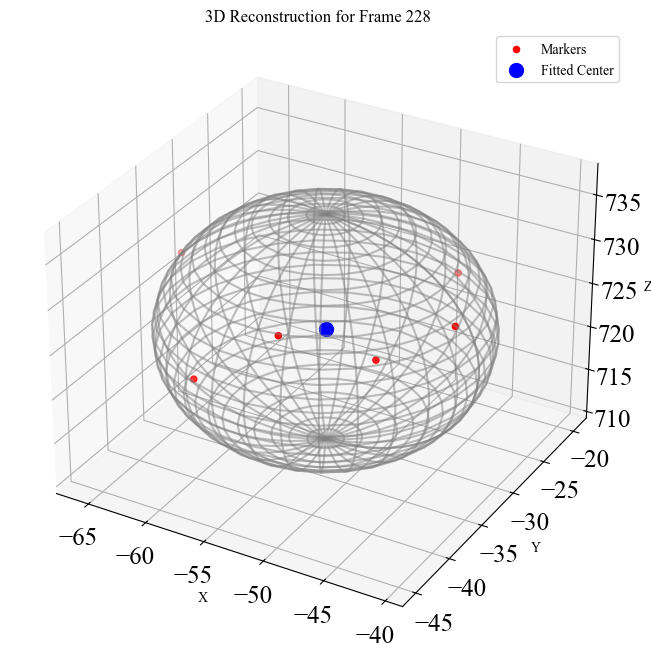

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_sample[:, 0], pts_sample[:, 1], pts_sample[:, 2], color='r', label="Markers")
ax.scatter(center_sample[0], center_sample[1], center_sample[2], color='b', s=100, label="Fitted Center")
# Plot a wireframe sphere for visualization
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 30)
x_sphere = center_sample[0] + radius_sample * np.outer(np.cos(u), np.sin(v))
y_sphere = center_sample[1] + radius_sample * np.outer(np.sin(u), np.sin(v))
z_sphere = center_sample[2] + radius_sample * np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='gray', alpha=0.5)
ax.set_title(f"3D Reconstruction for Frame {sample_frame}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [54]:
common_frames[228]

1559

In [50]:
# For instance, print average sphere radius and compare with known diameter.
known_diameter = 57.15  #mm (if that was your calibration unit)
known_radius = known_diameter / 2.0
print("Mean fitted radius:", np.mean(radii))
print("Known sphere radius:", known_radius)
print("Mean radius error:", np.mean(np.abs(radii - known_radius)))

Mean fitted radius: 28.55958592753347
Known sphere radius: 28.575
Mean radius error: 0.01541407246653009


In [13]:
# Save the sphere centers, radii, and orientations for further analysis
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\sphere_centers_v2.npy", centers)
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\sphere_radii_v2.npy", radii)
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\sphere_orientations_v2.npy", orientations)

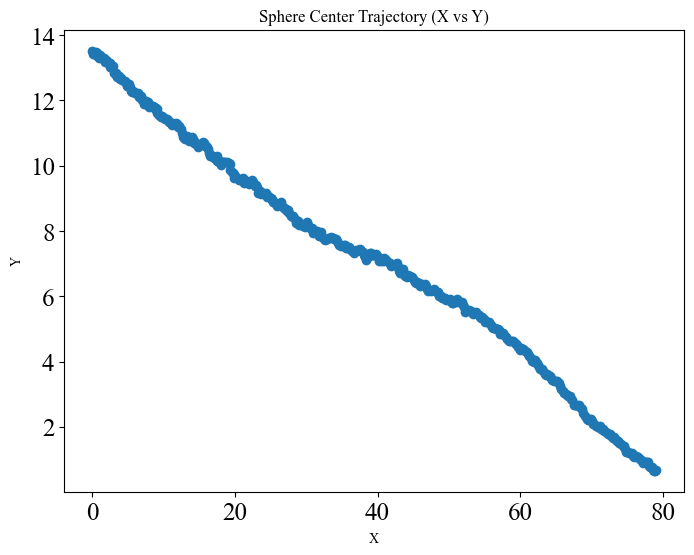

In [51]:
# (a) Plot sphere center trajectory (X vs. Y)
plt.figure(figsize=(8, 6))
plt.plot(centers[:-10, 0]-centers[0,0], -centers[:-10, 1]+centers[-1,1], marker='o', linestyle='-')
plt.title("Sphere Center Trajectory (X vs Y)")
plt.xlabel("X")
plt.ylabel("Y")
# plt.gca().invert_yaxis()  # Flip if needed to match image coordinates
plt.show()

## Position vs Time

In [35]:
print("Start time:",common_frames[0]*0.04)
print("End time:",common_frames[-1]*0.04)

Start time: 53.24
End time: 71.44


In [46]:
time = np.arange(53.24,71.45,0.04)
C_Mx = centers[:, 0]-centers[0,0]
C_My = -centers[:, 1]+centers[-1,1]
C_Mz = centers[:, 2]-centers[0,2]

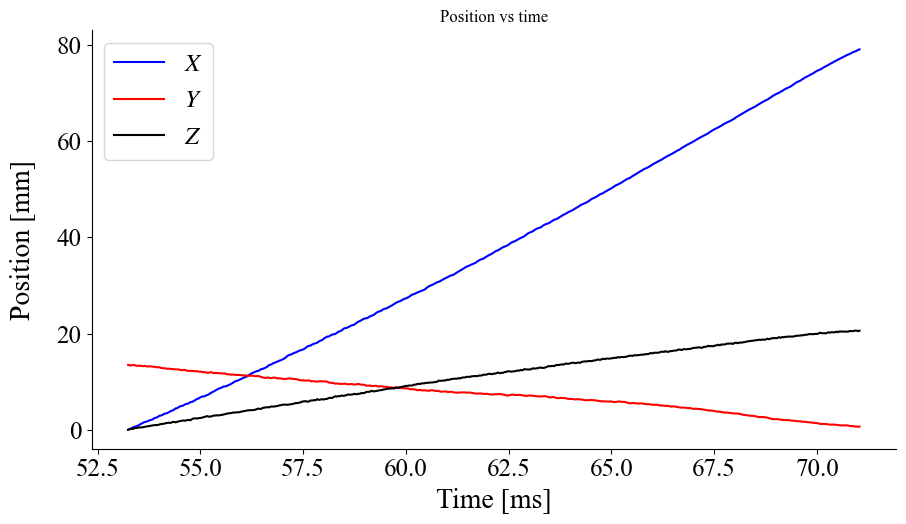

In [38]:
# (a) Plot sphere center trajectory (X vs. Y)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(time[:-10], centers[:-10, 0]-centers[0,0], 'b', label = r'$X$')
plt.plot(time[:-10], np.abs(-centers[:-10, 1]+centers[-1,1]), 'r', label = r'$Y$')
plt.plot(time[:-10], centers[:-10, 2]-centers[0,2], 'k', label = r'$Z$')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel('Position [mm]', rotation = 90, fontsize = 20, labelpad=15)

plt.title("Position vs time")
plt.legend(fontsize = 18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()


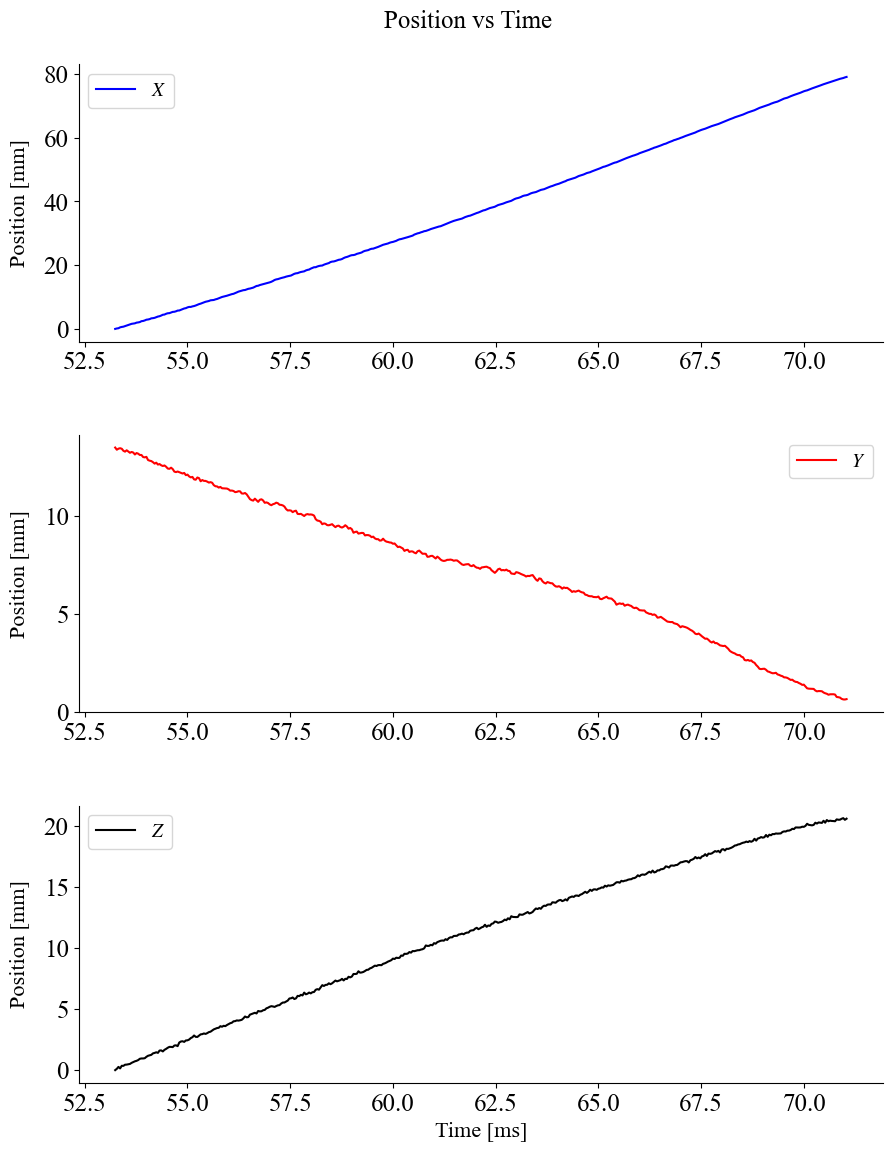

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.tight_layout(pad=5.0)
# Plot X position
def set_plot(ax, x, y, color, label):
    ax.plot(x, y, color, label=label)
    ax.set_ylabel('Position [mm]', fontsize=16, labelpad=10)
    ax.legend(fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

set_plot(axes[0], time[:-10], centers[:, 0][:-10] - centers[0, 0], 'b', r'$X$')
set_plot(axes[1], time[:-10], np.abs(-centers[:, 1][:-10] + centers[-1, 1]), 'r', r'$Y$')
set_plot(axes[2], time[:-10], centers[:, 2][:-10] - centers[0, 2], 'k', r'$Z$')

axes[2].set_xlabel('Time [ms]', fontsize=16)
fig.suptitle("Position vs Time", fontsize=18)

plt.show()

## Check radius of sphere across time 

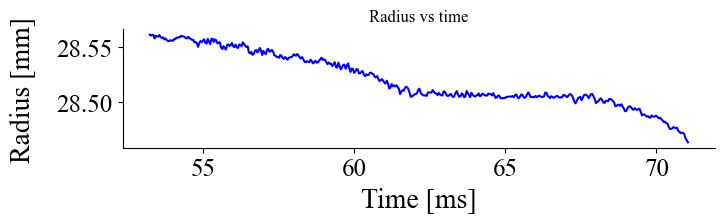

In [40]:
time = np.arange(53.24,71.45,0.04)

import matplotlib.ticker as ticker
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,3)
fig.tight_layout(pad=5.0)

plt.plot(time[:-10], radii[:-10], 'b', label = r'$Sphere Radius (mm)$')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel('Radius [mm]', rotation = 90, fontsize = 20, labelpad=15)

plt.title("Radius vs time")
# plt.legend(fontsize = 18)
#plt.ylim(28.558,28.562)
#ax.set_yticks([28.558,28.560,28.562])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

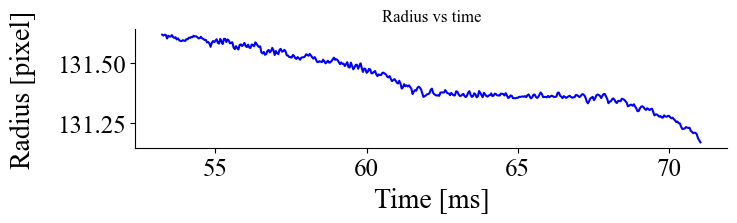

In [41]:
sf = 0.217

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,3)
fig.tight_layout(pad=5.0)

plt.plot(time[:-10], radii[:-10]/sf, 'b', label = r'$Sphere Radius (mm)$')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel('Radius [pixel]', rotation = 90, fontsize = 20, labelpad=15)

plt.title("Radius vs time")
# plt.legend(fontsize = 18)
#plt.ylim(131.5,131.7)
#ax.set_yticks([131.5,131.6,131.7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [34]:
np.max(radii-np.mean(radii))

0.04259026997398152

## Calculate Orientation

In [42]:
# Convert rotation matrices to Euler angles
euler_angles = [R.from_matrix(R_i).as_euler('zyx', degrees=True) for R_i in orientations]

# Convert to NumPy array (shape: num_frames, 3)
euler_angles = np.array(euler_angles)

# Extract yaw, pitch, roll
yaw = euler_angles[:, 0]   # Rotation around Z-axis
pitch = euler_angles[:, 1] # Rotation around Y-axis
roll = euler_angles[:, 2]  # Rotation around X-axis

# Print first frame's angles
print(f"Yaw: {yaw[0]:.2f}, Pitch: {pitch[0]:.2f}, Roll: {roll[0]:.2f}")

Yaw: 0.00, Pitch: 0.00, Roll: -0.00


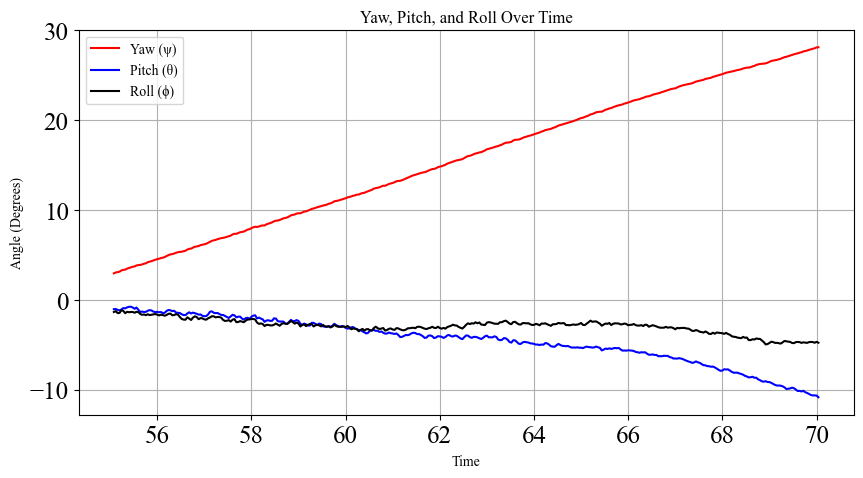

In [43]:
st = 46
ed = 421

plt.figure(figsize=(10, 5))
plt.plot(time[st:ed], yaw[st:ed], 'r', label="Yaw (ψ)")
plt.plot(time[st:ed], pitch[st:ed],'b', label="Pitch (θ)")
plt.plot(time[st:ed], roll[st:ed],'k', label="Roll (ϕ)")
plt.xlabel("Time")
plt.ylabel("Angle (Degrees)")
plt.title("Yaw, Pitch, and Roll Over Time")
plt.legend()
plt.grid()
plt.show()

## Approach 1: Moving Regression

In [316]:
#np.where((time >= 55) & (time <= 70))[0]
##use indices 46-421 for 55ms - 70ms

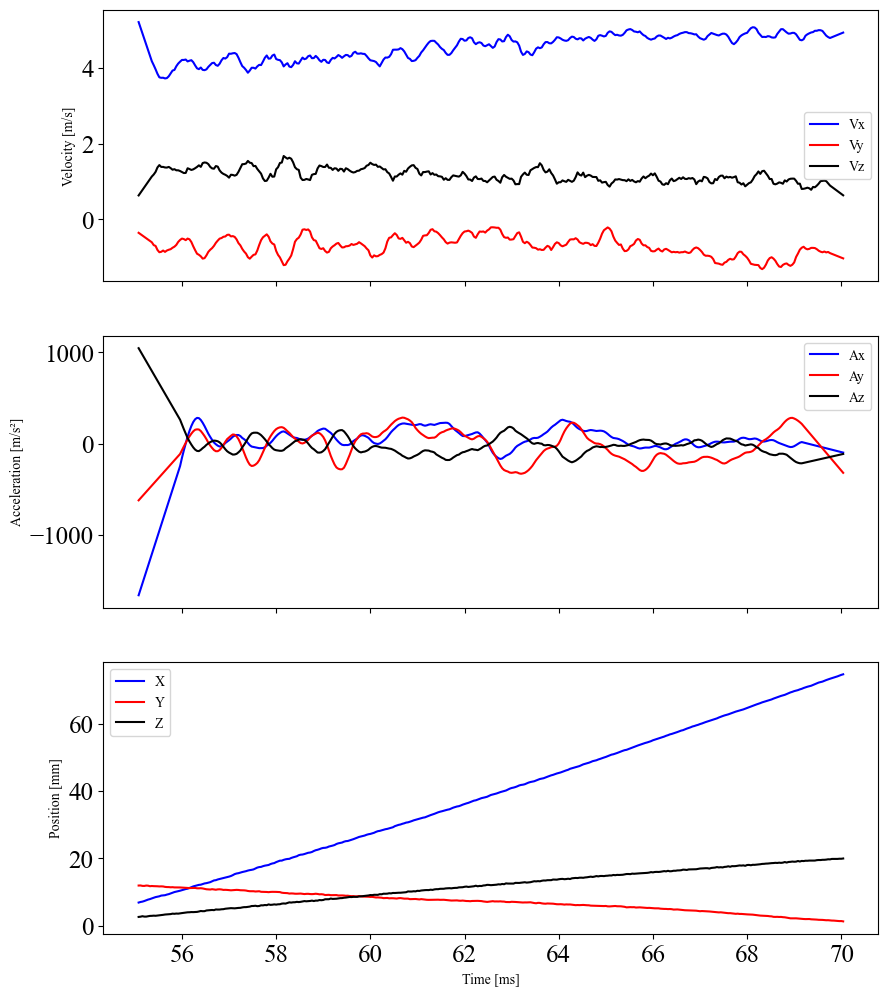

In [53]:
st = 46
ed = 421

# Sample time and displacement data
# time = np.array([...])  # Time values (ms)
X = C_Mx[st:ed]  # X-axis displacement
Y = C_My[st:ed]   # Y-axis displacement
Z = C_Mz[st:ed]   # Z-axis displacement
t = time[st:ed] 

# Apply Savitzky-Golay filter (a type of moving regression) for smoothing and differentiation
window_size_v = 15  # Use 5-point moving regression
window_size_a = 45  # Use 5-point moving regression
poly_order = 2   # Quadratic fitting

# Compute first derivative (velocity)
Vx = savgol_filter(X, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Vy = savgol_filter(Y, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Vz = savgol_filter(Z, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))


# Compute first derivative from velocity (acceleration)
Ax = savgol_filter(Vx, window_size_a, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Ay = savgol_filter(Vy, window_size_a, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Az = savgol_filter(Vz, window_size_a, poly_order, deriv=1, delta=np.mean(np.diff(time)))

# # Compute second derivative (acceleration)
# Ax = savgol_filter(X, window_size_a, poly_order, deriv=2, delta=np.mean(np.diff(time)))
# Ay = savgol_filter(Y, window_size_a, poly_order, deriv=2, delta=np.mean(np.diff(time)))
# Az = savgol_filter(Z, window_size_a, poly_order, deriv=2, delta=np.mean(np.diff(time)))

# Print or plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
ax[0].plot(t, Vx, label="Vx", color="b")
ax[0].plot(t, Vy, label="Vy", color="r")
ax[0].plot(t, Vz, label="Vz", color="k")
ax[0].set_ylabel("Velocity [m/s]")
ax[0].legend()

ax[1].plot(t, Ax*1000, label="Ax", color="b")
ax[1].plot(t, Ay*1000, label="Ay", color="r")
ax[1].plot(t, Az*1000, label="Az", color="k")
ax[1].set_ylabel("Acceleration [m/s²]")
ax[1].legend()

ax[2].plot(t, X, label="X", color="b")
ax[2].plot(t, Y, label="Y", color="r")
ax[2].plot(t, Z, label="Z", color="k")
ax[2].set_ylabel("Position [mm]")
ax[2].set_xlabel("Time [ms]")
ax[2].legend()

plt.show()


In [54]:
df_coeff=pd.DataFrame()
df_coeff['Time']=t
df_coeff['X']=X
df_coeff['Y']=Y
df_coeff['Z']=Z
df_coeff['Vx']=Vx
df_coeff['Vy']=Vy
df_coeff['Vz']=Vz
df_coeff['Ax']=Ax*1000
df_coeff['Ay']=Ay*1000
df_coeff['Az']=Az*1000
df_coeff['yaw'] = yaw[st:ed]
df_coeff['roll'] = roll[st:ed]
df_coeff['pitch'] = pitch[st:ed]
df_coeff.head()

,Time,X,Y,Z,Vx,Vy,Vz,Ax,Ay,Az,yaw,roll,pitch
0,55.08,6.897210,11.954178,2.623842,5.204980,-0.353200,0.632607,-1657.360990,-619.302472,1044.941934,2.958881,-1.345951,-1.030651
1,55.12,7.065553,11.978384,2.694539,5.057577,-0.388839,0.703862,-1593.151713,-596.251967,1009.387189,3.055277,-1.245936,-1.011382
2,55.16,7.171748,11.852963,2.835751,4.910175,-0.424479,0.775117,-1528.942436,-573.201461,973.832444,3.086578,-1.467512,-1.107455
3,55.20,7.346735,11.835688,2.723327,4.762772,-0.460118,0.846372,-1464.733159,-550.150956,938.277699,3.145256,-1.447533,-1.164697
4,55.24,7.563703,11.948002,2.717152,4.615369,-0.495757,0.917627,-1400.523883,-527.100450,902.722954,3.278732,-1.146163,-1.067532


In [55]:
m = 87.5/1000 # Mass, kg
r = 28.575/1000 #Radius, m
P0 = 6894.76*120 # Stagnation pressure, pa
P = 0.024226295980244256*6894.76 #Static pressure, pa
gamma = 1.4
M = 7.2 #Mach Number
A = np.pi*(r**2) # Reference area, m^2
q_inf = (1/2)*P*gamma*(M**2)  # Stagnation/dynammic pressure of test, Pa
g = 9.81 # Acceleration due to gravity, m/s^2
U_inf = 886.33 # Freestream velocity, m/s
rho= 0.022053985550548307
I_yy = (2/5)*m*(r**2) # Moment of inertia about the pitching axis/center of mass, kgm^2

In [56]:
df_coeff['C_D'] = (m*np.abs(df_coeff.Ax))/(q_inf*A)
df_coeff['C_L'] = (m*np.abs(df_coeff.Ay))/(q_inf*A)
df_coeff['C_z'] = (m*np.abs(df_coeff.Az))/(q_inf*A)

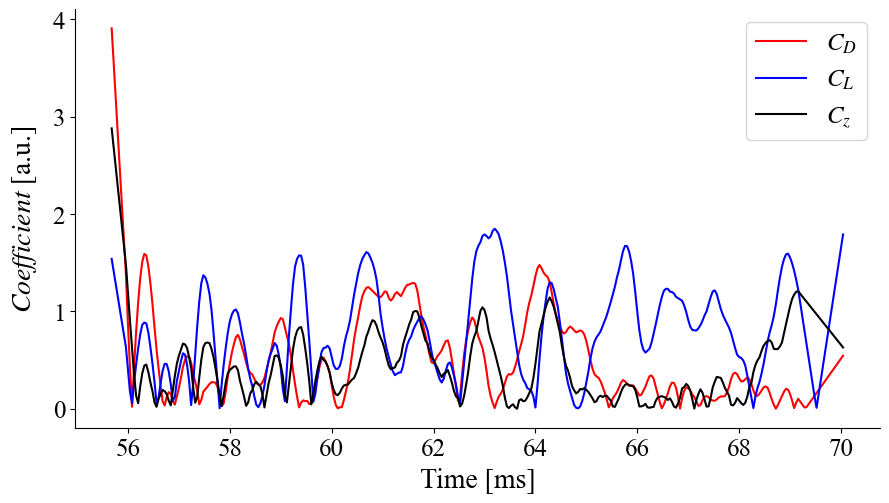

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_coeff.Time[20:], df_coeff.C_D[20:], 'r', label = r'$C_D$')
plt.plot(df_coeff.Time[20:], df_coeff.C_L[20:], 'b', label = r'$C_L$')
plt.plot(df_coeff.Time[20:], df_coeff.C_z[20:], 'k', label = r'$C_z$')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$Coefficient$ [a.u.]', rotation = 90, fontsize = 20, labelpad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

plt.legend(fontsize = 18)

plt.show()

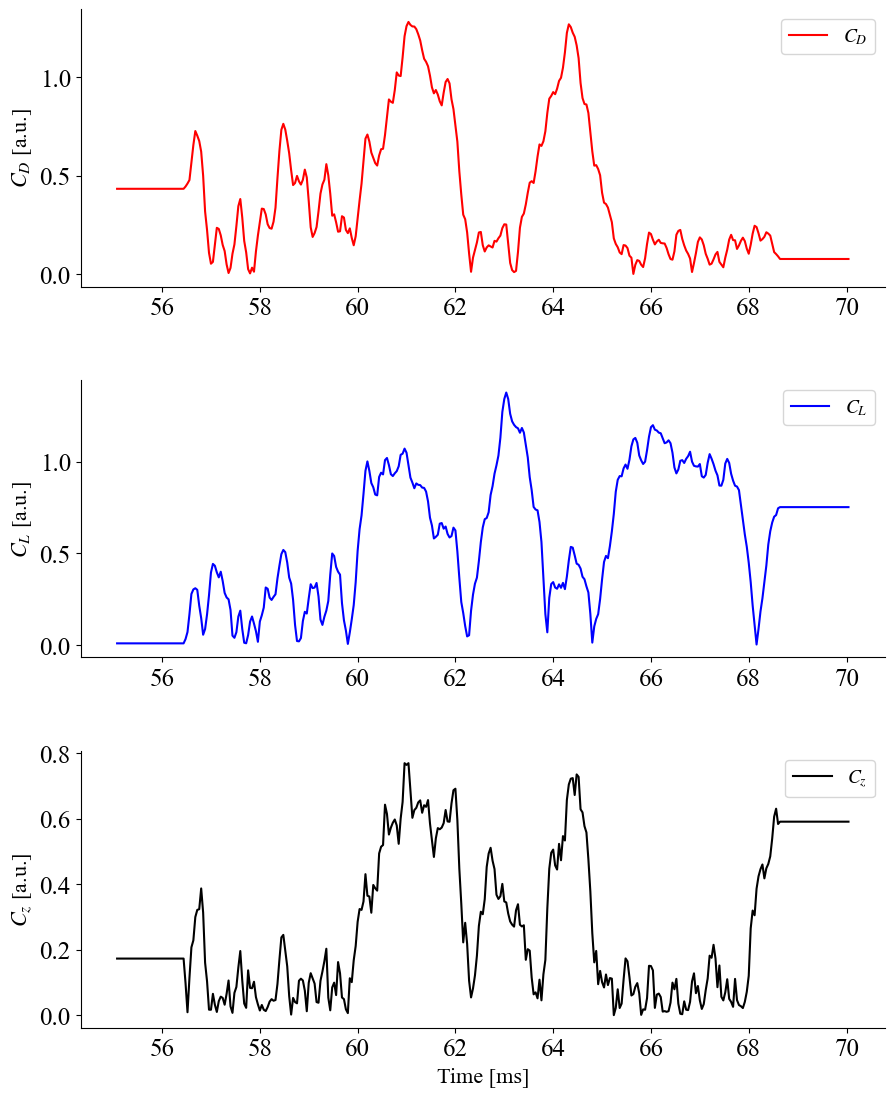

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.tight_layout(pad=5.0)

# Plot C_D
axes[0].plot(df_coeff.Time, df_coeff.C_D, 'r', label=r'$C_D$')
axes[0].set_ylabel(r'$C_D$ [a.u.]', fontsize=16)
axes[0].legend(fontsize=14)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

# Plot C_L
axes[1].plot(df_coeff.Time, df_coeff.C_L, 'b', label=r'$C_L$')
axes[1].set_ylabel(r'$C_L$ [a.u.]', fontsize=16)
axes[1].legend(fontsize=14)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

# Plot C_z
axes[2].plot(df_coeff.Time, df_coeff.C_z, 'k', label=r'$C_z$')
axes[2].set_xlabel('Time [ms]', fontsize=16)
axes[2].set_ylabel(r'$C_z$ [a.u.]', fontsize=16)
axes[2].legend(fontsize=14)
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].yaxis.set_ticks_position('left')
axes[2].xaxis.set_ticks_position('bottom')

plt.show()


In [92]:
df_coeff.to_csv(r"D:\FST_972_FF_Sphere\FST_972_Run\aerocoeff_df2.csv",index=False)

In [324]:
print(centers.shape)
print(radii.shape)
print(orientations.shape)

(457, 3)
(457,)
(457, 3, 3)


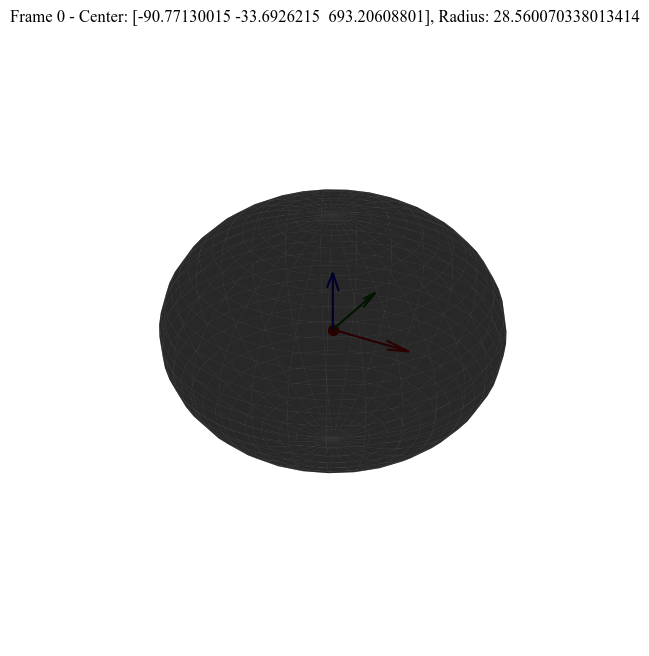

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load your data (Using the first frame for testing)
index = 0  # You can change this to test different frames

center = centers[index]  # [X, Y, Z]
radius = radii[index]    # Radius value
orientation = orientations[index]  # Rotation matrix

def create_sphere(radius, center, rotation_matrix):
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

    # Flatten and apply rotation
    points = np.array([x.flatten(), y.flatten(), z.flatten()])
    rotated_points = rotation_matrix @ points

    # Reshape rotated points
    x_rot = rotated_points[0].reshape(x.shape) + center[0]
    y_rot = rotated_points[1].reshape(y.shape) + center[1]
    z_rot = rotated_points[2].reshape(z.shape) + center[2]

    return x_rot, y_rot, z_rot

# Plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate and plot the rotated sphere
x_rot, y_rot, z_rot = create_sphere(radius, center, orientation)
ax.plot_surface(x_rot, y_rot, z_rot, color='k', alpha=0.6)

# Plot the sphere's center
ax.scatter(center[0], center[1], center[2], color='red', s=50)

# Plot X, Y, Z axes centered at the sphere's center
axis_length = 0.5 * radius  # Length of the axis lines
ax.quiver(center[0], center[1], center[2], axis_length, 0, 0, color='r', label='X-axis')
ax.quiver(center[0], center[1], center[2], 0, axis_length, 0, color='g', label='Y-axis')
ax.quiver(center[0], center[1], center[2], 0, 0, axis_length, color='b', label='Z-axis')

# Remove grid, axes, and labels
ax.grid(False)
ax.set_axis_off()

plt.title(f'Frame {index} - Center: {center}, Radius: {radius}')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Create output folder for frames
output_folder = 'generated_frames'
os.makedirs(output_folder, exist_ok=True)

def create_sphere(radius, center, rotation_matrix):
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

    # Flatten and apply rotation
    points = np.array([x.flatten(), y.flatten(), z.flatten()])
    rotated_points = rotation_matrix @ points

    # Reshape rotated points
    x_rot = rotated_points[0].reshape(x.shape) + center[0]
    y_rot = rotated_points[1].reshape(y.shape) + center[1]
    z_rot = rotated_points[2].reshape(z.shape) + center[2]

    return x_rot, y_rot, z_rot

for index, (center, radius, orientation) in enumerate(zip(centers, radii, orientations)):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Generate and plot the rotated sphere
    x_rot, y_rot, z_rot = create_sphere(radius, center, orientation)
    ax.plot_surface(x_rot, y_rot, z_rot, color='k', alpha=0.6)

    # Plot the sphere's center
    ax.scatter(center[0], center[1], center[2], color='red', s=50)

    # Plot X, Y, Z axes centered at the sphere's center
    axis_length = 0.5 * radius
    ax.quiver(center[0], center[1], center[2], axis_length, 0, 0, color='r')  # X-axis
    ax.quiver(center[0], center[1], center[2], 0, axis_length, 0, color='g')  # Y-axis
    ax.quiver(center[0], center[1], center[2], 0, 0, axis_length, color='b')  # Z-axis

    # Remove grid, axes, and labels
    ax.grid(False)
    ax.set_axis_off()

    # Save frame
    plt.savefig(f'{output_folder}/frame_{index:04d}.png')
    plt.close()


## Approach 2: Curve Fit

In [ ]:

# Define Interactive Function
def f(n):
    x = time
    y = C_Mx

    # Fit polynomial of degree n
    curve_model = np.poly1d(np.polyfit(x, y, n))

    # Generate fitted curve points
    curve_fitting_line = np.linspace(x.min(), x.max(), 1000)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(x, y, color='r', label="Data Points")
    ax.plot(curve_fitting_line, curve_model(curve_fitting_line), label=f"Poly Fit (n={n})", linewidth=2)
    
    ax.set_xlabel("Time [ms]", fontsize=14)
    ax.set_ylabel("Position [mm]", fontsize=14)
    ax.set_title(r"$C_{M,x}$ Curve Fit", fontsize=16)
    
    ax.legend()
    plt.grid()
    plt.show()

# Create Interactive Widget
interactive_plot = interactive(f, n=widgets.IntSlider(min=1, max=4, step=1, value=2, description="Polynomial Degree"))

interactive_plot


interactive(children=(IntSlider(value=2, description='Polynomial Degree', max=4, min=1), Output()), _dom_class…

In [49]:
df_fit=pd.DataFrame()

In [50]:
# Save the fit to the new dataframe
x = time
y = C_Mx

order = 1

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(time),1)))
V_fit = np.squeeze(np.zeros((len(time),1)))
A_fit = np.squeeze(np.zeros((len(time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*time**(order-i)
    V_fit = V_fit + c*(order-i)*time**(order-i-1)
    A_fit = A_fit + c*(order-i)*(order-i-1)*time**(order-i-2)*1000
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['C_Mx'] = fit
df_fit['Vx'] = V_fit
df_fit['Ax'] = A_fit

Curve Fit:
['5.5332t^1', '-299.378t^0']


In [51]:
# Save the fit to the new dataframe
x = time
y = C_My

order = 3

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(time),1)))
V_fit = np.squeeze(np.zeros((len(time),1)))
A_fit = np.squeeze(np.zeros((len(time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*time**(order-i)
    V_fit = V_fit + c*(order-i)*time**(order-i-1)
    A_fit = A_fit + c*(order-i)*(order-i-1)*time**(order-i-2)*1000
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['C_My'] = fit
df_fit['Vy'] = V_fit
df_fit['Ay'] = A_fit

Curve Fit:
['-0.0035t^3', '0.689t^2', '-45.5715t^1', '1018.0152t^0']


In [52]:
# Save the fit to the new dataframe
x = time
y = C_Mz

order = 3

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(time),1)))
V_fit = np.squeeze(np.zeros((len(time),1)))
A_fit = np.squeeze(np.zeros((len(time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*time**(order-i)
    V_fit = V_fit + c*(order-i)*time**(order-i-1)
    A_fit = A_fit + c*(order-i)*(order-i-1)*time**(order-i-2)*1000
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['C_Mz'] = fit
df_fit['Vz'] = V_fit
df_fit['Az'] = A_fit

Curve Fit:
['-0.0024t^3', '0.4632t^2', '-28.9168t^1', '595.1754t^0']


In [53]:
df_fit["Time"] = time
df_fit.head()

,C_Mx,Vx,Ax,C_My,Vy,Ay,C_Mz,Vz,Az,Time
0,-0.362788,5.53322,0.0,13.427524,-1.860066,239.727550,0.052600,-0.237321,134.955004,54.04
1,-0.141459,5.53322,0.0,13.353312,-1.850493,238.884996,0.043215,-0.231934,134.369137,54.08
2,0.079869,5.53322,0.0,13.279484,-1.840955,238.042442,0.034045,-0.226571,133.783270,54.12
3,0.301198,5.53322,0.0,13.206036,-1.831450,237.199889,0.025089,-0.221232,133.197404,54.16
4,0.522527,5.53322,0.0,13.132967,-1.821979,236.357335,0.016347,-0.215915,132.611537,54.20


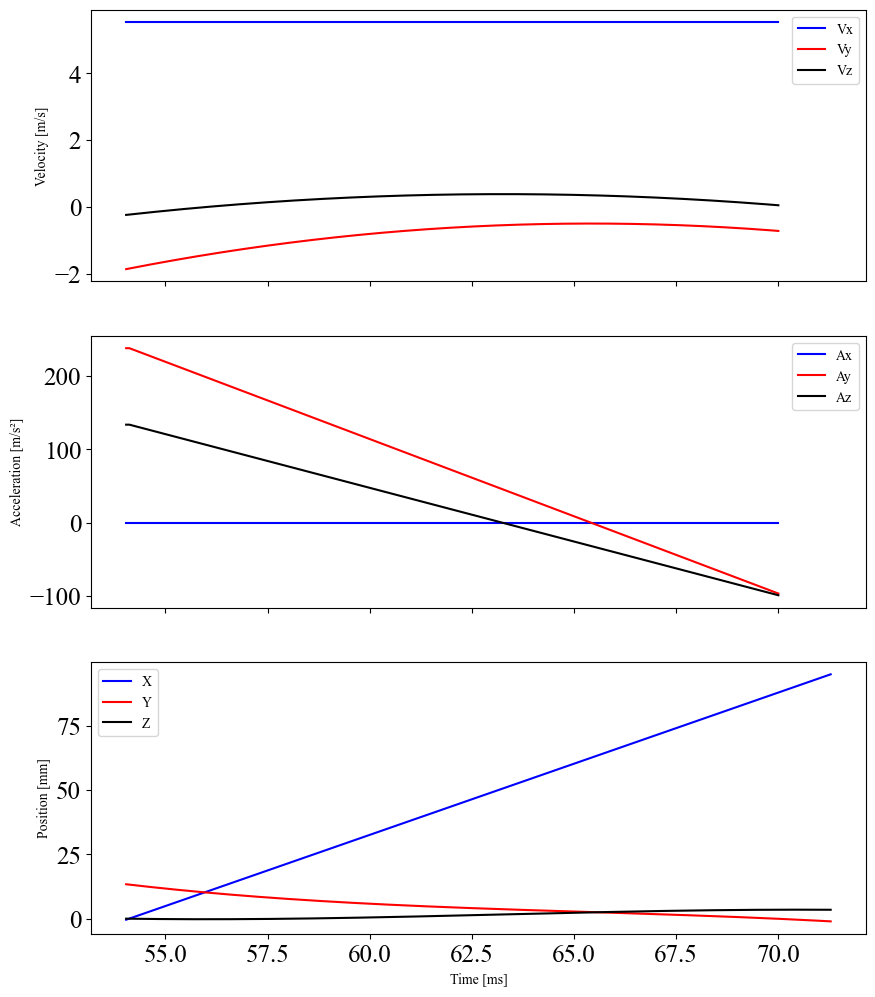

In [271]:
import numpy as np
from scipy.signal import savgol_filter

# Sample time and displacement data
time = df_fit['Time']#np.array([...])  # Time values (ms)
X = df_fit['C_Mx']  # X-axis displacement
Y = df_fit['C_My']  # Y-axis displacement
Z = df_fit['C_Mz']  # Z-axis displacement

# Apply Savitzky-Golay filter (a type of moving regression) for smoothing and differentiation
window_size_v = 5  # Use 5-point moving regression
window_size_a = 5  # Use 5-point moving regression
poly_order = 2   # Quadratic fitting

# Compute first derivative (velocity)
Vx = savgol_filter(X, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Vy = savgol_filter(Y, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))
Vz = savgol_filter(Z, window_size_v, poly_order, deriv=1, delta=np.mean(np.diff(time)))

# Compute second derivative (acceleration)
Ax = savgol_filter(X, window_size_a, poly_order, deriv=2, delta=np.mean(np.diff(time)))
Ay = savgol_filter(Y, window_size_a, poly_order, deriv=2, delta=np.mean(np.diff(time)))
Az = savgol_filter(Z, window_size_a, poly_order, deriv=2, delta=np.mean(np.diff(time)))

# Print or plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
ax[0].plot(time[:-32], Vx[:-32], label="Vx", color="b")
ax[0].plot(time[:-32], Vy[:-32], label="Vy", color="r")
ax[0].plot(time[:-32], Vz[:-32], label="Vz", color="k")
ax[0].set_ylabel("Velocity [m/s]")
ax[0].legend()

ax[1].plot(time[:-32], Ax[:-32]*1000, label="Ax", color="b")
ax[1].plot(time[:-32], Ay[:-32]*1000, label="Ay", color="r")
ax[1].plot(time[:-32], Az[:-32]*1000, label="Az", color="k")
ax[1].set_ylabel("Acceleration [m/s²]")
ax[1].legend()

ax[2].plot(time, X, label="X", color="b")
ax[2].plot(time, Y, label="Y", color="r")
ax[2].plot(time, Z, label="Z", color="k")
ax[2].set_ylabel("Position [mm]")
ax[2].set_xlabel("Time [ms]")
ax[2].legend()

plt.show()

## Approach 3: Tikhonov Regularization

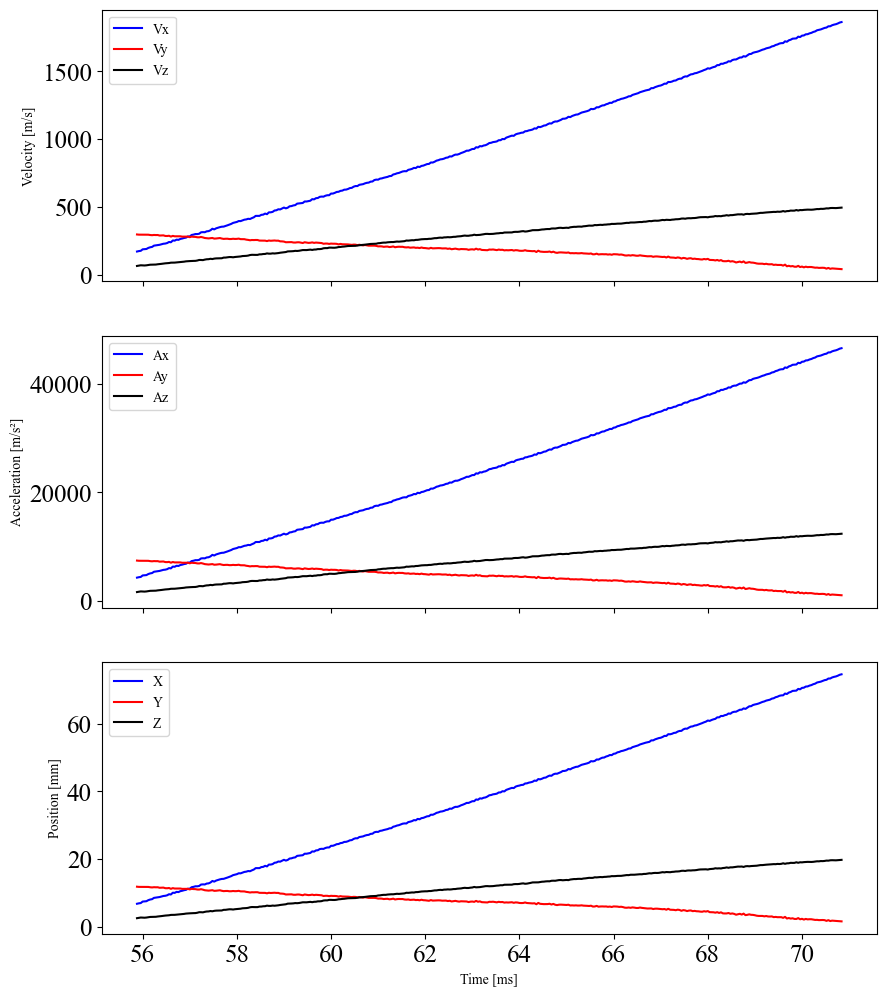

In [329]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.sparse import diags


def finite_difference_matrix(n, order=1):
    """
    Generates a finite difference matrix of specified order (1 for velocity, 2 for acceleration).
    """
    if order == 1:  # First-order difference matrix (L1 for velocity)
        D = diags([-1, 1], [0, 1], shape=(n - 1, n)).toarray()
    elif order == 2:  # Second-order difference matrix (L2 for acceleration)
        D = diags([1, -2, 1], [0, 1, 2], shape=(n - 2, n)).toarray()
    else:
        raise ValueError("Only order 1 and 2 are supported.")
    return D


def tikhonov_regularization(b, A, L, lambd):
    """
    Solves the Tikhonov regularization problem: (A.T A + lambda^2 L.T L) x = A.T b
    """
    ATA = A.T @ A
    LTL = L.T @ L
    reg_matrix = ATA + lambd**2 * LTL
    rhs = A.T @ b
    x = lstsq(reg_matrix, rhs)[0]
    return x


def compute_derivative(data, time, order=1, lambd=1e-3):
    """
    Computes the derivative using Tikhonov regularization.
    """
    n = len(data)
    dt = np.mean(np.diff(time))

    # Design matrix for finite difference approximation
    A = np.eye(n)

    # Regularization matrix
    L = finite_difference_matrix(n, order=order)

    # Solve for the derivative
    derivative = tikhonov_regularization(data, A, L, lambd) / (dt**order)
    return derivative


# Example usage
st = 46
ed = 421


t = time[st:ed]
X = C_Mx[st:ed]
Y = C_My[st:ed]
Z = C_Mz[st:ed]

# Choose regularization parameter
lambda_v = 1e-3  # For velocity
lambda_a = 1e-4  # For acceleration

# Compute velocity
Vx = compute_derivative(X, t, order=1, lambd=lambda_v)
Vy = compute_derivative(Y, t, order=1, lambd=lambda_v)
Vz = compute_derivative(Z, t, order=1, lambd=lambda_v)

# Compute acceleration
Ax = compute_derivative(X, t, order=2, lambd=lambda_a)
Ay = compute_derivative(Y, t, order=2, lambd=lambda_a)
Az = compute_derivative(Z, t, order=2, lambd=lambda_a)


# Plotting results
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

ax[0].plot(t, Vx, label="Vx", color="b")
ax[0].plot(t, Vy, label="Vy", color="r")
ax[0].plot(t, Vz, label="Vz", color="k")
ax[0].set_ylabel("Velocity [m/s]")
ax[0].legend()

ax[1].plot(t, Ax, label="Ax", color="b")
ax[1].plot(t, Ay, label="Ay", color="r")
ax[1].plot(t, Az, label="Az", color="k")
ax[1].set_ylabel("Acceleration [m/s²]")
ax[1].legend()

ax[2].plot(t, X, label="X", color="b")
ax[2].plot(t, Y, label="Y", color="r")
ax[2].plot(t, Z, label="Z", color="k")
ax[2].set_ylabel("Position [mm]")
ax[2].set_xlabel("Time [ms]")
ax[2].legend()

plt.show()


## Alternate 3D Reconstruction

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2819e+04                                    1.53e+06    
       1              5         6.0893e+03      6.73e+03       4.46e-01       1.91e+05    
       2              6         4.3655e+03      1.72e+03       4.46e-01       2.36e+04    
       3              7         4.1529e+03      2.13e+02       4.46e-01       1.56e+04    
       4              8         3.6545e+03      4.98e+02       4.46e-01       3.04e+03    
       5             11         3.6457e+03      8.73e+00       2.79e-02       2.97e+03    
       6             12         3.6309e+03      1.48e+01       6.97e-03       1.24e+03    
       7             13         3.6276e+03      3.34e+00       1.39e-02       1.18e+03    
       8             14         3.6256e+03      2.00e+00       1.39e-02       1.32e+03    
       9             15         3.6222e+03      3.35e+00       3.49e-03       5.28e+02    

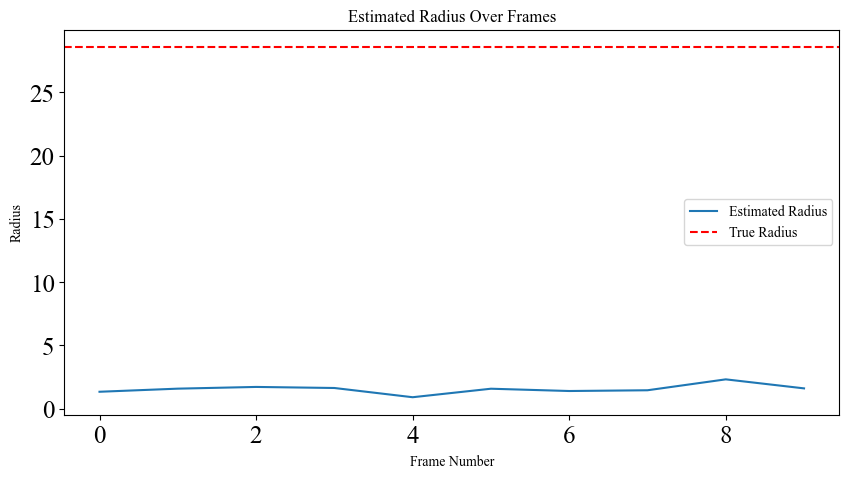

In [330]:
# Import necessary libraries
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def project_points(points, K, R, T):
    """
    Projects 3D points to 2D image points using intrinsic matrix K, rotation R, and translation T.
    """
    points_cam = R @ points.T + T[:, np.newaxis]
    points_proj = (points_cam[:2, :] / points_cam[2, :]).T
    points_proj = K @ np.vstack((points_proj.T, np.ones(points_proj.shape[0])))
    return points_proj[:2, :].T


def bundle_adjustment(params, points_per_frame, K1, K2):
    """
    Perform bundle adjustment to optimize sphere centers, radii, and orientations.
    """
    num_frames = len(points_per_frame)
    residuals = []

    for i in range(num_frames):
        # Extract frame-specific parameters
        cx, cy, cz, r = params[i*7:i*7+4]
        qx, qy, qz = params[i*7+4:i*7+7]

        # Convert quaternion to rotation matrix
        R_i = np.eye(3)  # Assuming identity for simplicity (we will update this later)

        # Extract 3D points
        points = points_per_frame[i]

        # Project points to both cameras
        proj_points1 = project_points(points - np.array([cx, cy, cz]), K1, R_i, np.zeros(3))
        proj_points2 = project_points(points - np.array([cx, cy, cz]), K2, R_i, np.zeros(3))

        # Compute reprojection errors
        error1 = (proj_points1 - points[:, :2]).ravel()
        error2 = (proj_points2 - points[:, :2]).ravel()

        residuals.append(np.concatenate([error1, error2]))

    return np.concatenate(residuals)


def run_bundle_adjustment(points_per_frame, K1, K2):
    """
    Optimize sphere fitting using Bundle Adjustment across all frames.
    """
    num_frames = len(points_per_frame)

    # Initial parameters
    params = []
    for i in range(num_frames):
        points = points_per_frame[i]
        initial_center = np.mean(points, axis=0)
        initial_radius = np.mean(np.linalg.norm(points - initial_center, axis=1))
        initial_orientation = [0, 0, 0]  # Quaternion approximation (to be improved)
        params.extend([*initial_center, initial_radius, *initial_orientation])

    params = np.array(params)

    # Perform bundle adjustment
    result = least_squares(bundle_adjustment, params, args=(points_per_frame, K1, K2), verbose=2)

    # Extract optimized parameters
    optimized_params = result.x

    # Extract optimized centers, radii, and orientations
    centers = []
    radii = []
    orientations = []
    for i in range(num_frames):
        cx, cy, cz, r = optimized_params[i*7:i*7+4]
        centers.append([cx, cy, cz])
        radii.append(r)
        orientations.append([0, 0, 0])  # Placeholder for orientation extraction

    return np.array(centers), np.array(radii), np.array(orientations)


# Example Usage (replace with your data)
K1 = np.eye(3)  # Intrinsic matrix for camera 1 (Replace with your calibration data)
K2 = np.eye(3)  # Intrinsic matrix for camera 2 (Replace with your calibration data)

num_frames = 10  # Example number of frames
points_per_frame = [np.random.randn(6, 3) + np.array([i, i, i]) for i in range(num_frames)]

# Run Bundle Adjustment
centers, radii, orientations = run_bundle_adjustment(points_per_frame, K1, K2)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(radii, label='Estimated Radius')
plt.axhline(y=57.12/2, color='r', linestyle='--', label='True Radius')
plt.legend()
plt.title('Estimated Radius Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Radius')
plt.show()